In [15]:
begin
    using Pkg
    Pkg.activate("../")
    Pkg.instantiate()
end

include("../modules/DataIO.jl")
include("../modules/Model.jl")
include("../modules/NaiveBayes.jl")

using FASTX,
    Plots,
    FLoops,
    .NaiveBayes,
    DecisionTree,
    LinearAlgebra,
    .DataIO,
    .Model


  Activating project at `~/Desktop/rrm-genomic-extractor`


In [16]:
modelCachedFile::String = "../.project_cache/0.004/kmers_distribution.dat"
model = DataIO.load_cache(modelCachedFile)


Main.NaiveBayes.MultiClassNaiveBayes(["Omicron", "Beta", "Gamma", "Delta", "Alpha"], Dict("Omicron" => 0.04836293601540766, "Beta" => 0.029745345602396746, "Gamma" => 0.3013053712818318, "Delta" => 0.33105071688422855, "Alpha" => 0.28953563021613526), Dict("Omicron" => [0.003519471443999746, 0.003541706371895051, 0.0035099421891874724, 0.0, 0.0, 0.007004002287021155, 0.002345255489909578, 0.0034940600978336828, 0.0, 0.0, 0.0035258242805412615, 0.0, 6.352836541515787e-5, 0.016235732587933847, 0.00913114372233869, 0.014050356817652414], "Beta" => [0.004044639264765051, 0.0036211168286639983, 1.5882091353789467e-5, 0.0, 0.0, 0.0034908836795629248, 0.003320415899032251, 0.00031128899053427353, 1.4823285263536836e-5, 0.0, 4.76462740613684e-5, 0.0, 1.5882091353789467e-5, 0.02163352603604176, 0.00902632191940368, 0.0034993541282849457], "Gamma" => [0.007834106261779218, 0.011322872329161637, 0.012501323507612816, 0.0002541134616606315, 0.0004923448319674735, 0.00012705673083031574, 0.00477098

In [17]:
@show model.priors

model.priors = Dict("Omicron" => 0.04836293601540766, "Beta" => 0.029745345602396746, "Gamma" => 0.3013053712818318, "Delta" => 0.33105071688422855, "Alpha" => 0.28953563021613526)


Dict{String, Float64} with 5 entries:
  "Omicron" => 0.0483629
  "Beta"    => 0.0297453
  "Gamma"   => 0.301305
  "Delta"   => 0.331051
  "Alpha"   => 0.289536

In [18]:
@show model.regions

model.regions = [(1, 1492), (1545, 4592), (4728, 7387), (7644, 8097), (8172, 9321), (9410, 10542), (10737, 11616), (11934, 13279), (13598, 14229), (14447, 14785), (14915, 18826), (18967, 19842), (20052, 20514), (20938, 23823), (23931, 26885), (26926, 29885)]


16-element Vector{Tuple{Int64, Int64}}:
 (1, 1492)
 (1545, 4592)
 (4728, 7387)
 (7644, 8097)
 (8172, 9321)
 (9410, 10542)
 (10737, 11616)
 (11934, 13279)
 (13598, 14229)
 (14447, 14785)
 (14915, 18826)
 (18967, 19842)
 (20052, 20514)
 (20938, 23823)
 (23931, 26885)
 (26926, 29885)

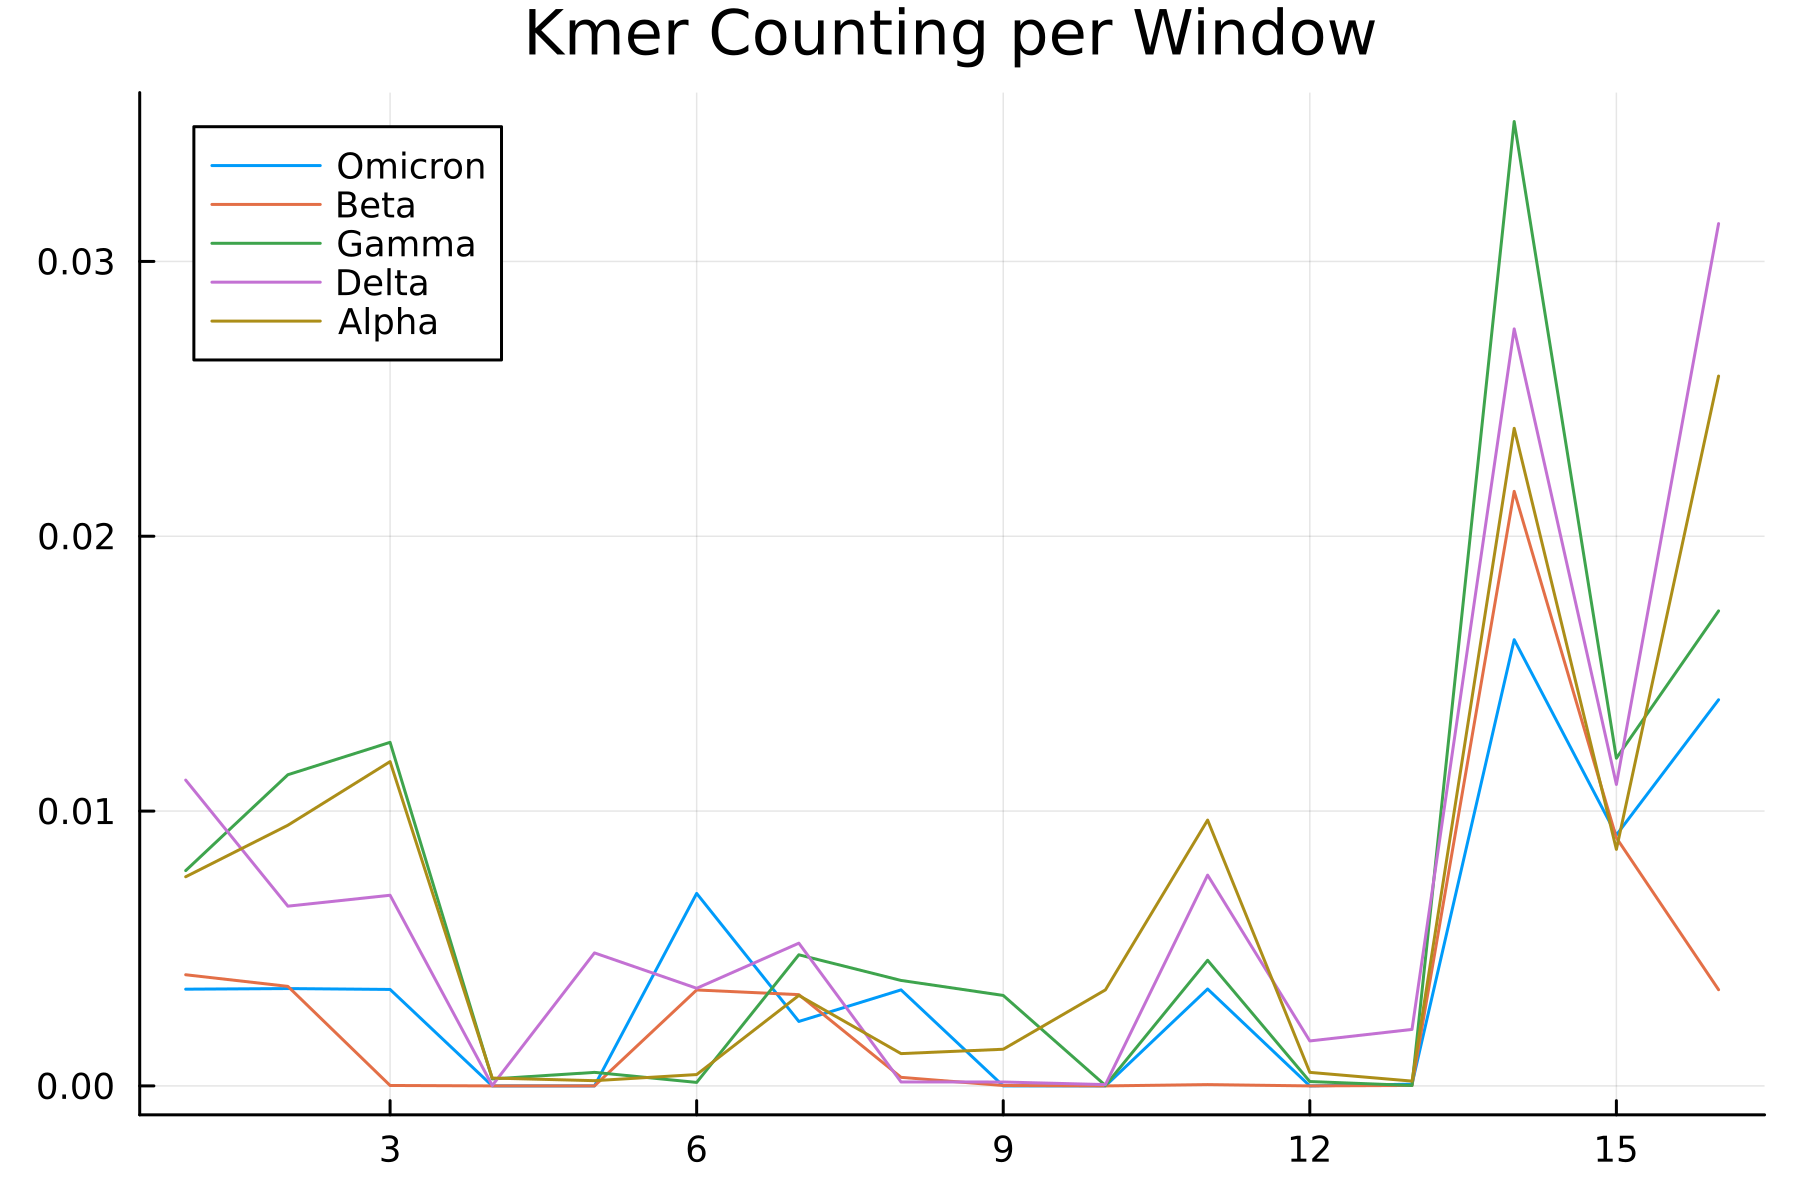

In [20]:

plt = plot(title="Kmer Counting per Window", dpi=300)

for (class, distribution) in  model.class_string_probs
    plot!(plt,distribution, label=class)
end

plot(plt)
# savefig("kmer_count_per_window.pdf")


### Collectiong histogram as datasets

1. Define Hyperparams and data variables

In [2]:
wnwPercent::Float32 = 0.004
variantDirPath::String = "/home/salipe/Desktop/datasets/tutorial_data/kmers"

cachdir::String = "$(pwd())/.project_cache/$wnwPercent"

try
    mkpath(cachdir)
catch e
    @error "create cache direcotry failed" exception = (e, catch_backtrace())
end

"/home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004"

2. Load Kmers set

In [3]:
variantDirs::Vector{String} = readdir(variantDirPath)
kmerset = Set{String}()

@simd for variant in variantDirs
    variantKmers = DataIO.read_pickle_data("$variantDirPath/$variant/$(variant)_ExclusiveKmers.sav")
    union!(kmerset, Set(variantKmers))
end

kmerset

Set{String} with 4293 elements:
  "TAAAATCAGCACCTT"
  "GGAATTTCAAGAACT"
  "GTCTACTACAGTCAG"
  "GTGGTCTCCCTCAGG"
  "GAACCGACGATGACT"
  "GTTAGTGCTAAATCA"
  "ATGGCTGTGATGCTG"
  "CTTCTAGAGTTCTTG"
  "ATTACATTATAAACC"
  "GTTTTTTTATGTACT"
  "ATAACTTTTAAAGAA"
  "GCTATGCCTTCGAAT"
  "CATCTAGATGGTGAA"
  "CTTGTTTTAAGCTTT"
  "TTACCACAGAAATTT"
  "TAGAGTGTTAGGTTT"
  "GGTTGGGAACTTGTT"
  "GATAATAGGCTTAAA"
  "TACACACAACACATT"
  ⋮ 

In [46]:
struct VariantDataloader
    meta_data::Dict{String,Int}
    byte_seqs::Dict{String,Vector{Base.CodeUnits}}
    wnw_size::Int
end

function def_kmer_classes_probs(
    kmer::Base.CodeUnits,
    data::VariantDataloader)::Dict{String,Vector{UInt64}}
    fn_occursin = Base.Fix1(Model.occursinKmerBit, kmer)

    appearance = Dict{String,Vector{UInt64}}()

    for class in keys(data.meta_data)

        seq_windows = maximum(length, data.byte_seqs[class]) - data.wnw_size + 1
        seq_hist = zeros(UInt64, seq_windows)

         for seq in data.byte_seqs[class]
            seq_windows = length(seq) - data.wnw_size + 1

            for initPos in 1:seq_windows
                endPos = initPos + data.wnw_size - 1
                wndw_buffer = @view seq[initPos:endPos]

                if fn_occursin(wndw_buffer)
                     seq_hist[initPos] += 1
                end
            end

        end

        appearance[class] = seq_hist
    end

    appearance
end

def_kmer_classes_probs (generic function with 1 method)

In [5]:
meta_data = Dict{String,Int}()
byte_seqs = Dict{String,Vector{Base.CodeUnits}}()
wnw_size = one(Int)

for variant in variantDirs
    byte_seqs[variant] =  Vector{Base.CodeUnits}()

    for record in open(FASTAReader, "$variantDirPath/$variant/$variant.fasta")
        push!(byte_seqs[variant], codeunits(sequence(String, record)))
    end

    minSeqLength::Int = minimum(map(length, byte_seqs[variant]))
    if (wnw_size == one(Int)||wnw_size >minSeqLength)
        wnw_size = ceil(Int, minSeqLength * wnwPercent)
    end

    meta_data[variant] = length(byte_seqs[variant])
end

dataloader = VariantDataloader(meta_data, byte_seqs, wnw_size)



VariantDataloader(Dict("Omicron" => 220, "Beta" => 220, "Gamma" => 220, "Delta" => 220, "Alpha" => 220), Dict{String, Vector{Base.CodeUnits}}("Omicron" => [UInt8[0x41, 0x47, 0x41, 0x54, 0x43, 0x54, 0x47, 0x54, 0x54, 0x43  …  0x41, 0x47, 0x54, 0x47, 0x43, 0x54, 0x41, 0x54, 0x43, 0x43], UInt8[0x41, 0x41, 0x43, 0x41, 0x41, 0x41, 0x43, 0x43, 0x41, 0x41  …  0x54, 0x54, 0x54, 0x54, 0x41, 0x41, 0x54, 0x41, 0x47, 0x43], UInt8[0x54, 0x43, 0x47, 0x41, 0x54, 0x43, 0x54, 0x43, 0x54, 0x54  …  0x54, 0x47, 0x54, 0x47, 0x54, 0x41, 0x41, 0x41, 0x41, 0x54], UInt8[0x41, 0x43, 0x54, 0x54, 0x54, 0x43, 0x47, 0x41, 0x54, 0x43  …  0x41, 0x47, 0x54, 0x47, 0x43, 0x54, 0x41, 0x54, 0x43, 0x43], UInt8[0x41, 0x43, 0x54, 0x54, 0x54, 0x43, 0x47, 0x41, 0x54, 0x43  …  0x41, 0x47, 0x54, 0x47, 0x43, 0x54, 0x41, 0x54, 0x43, 0x43], UInt8[0x41, 0x43, 0x54, 0x54, 0x54, 0x43, 0x47, 0x41, 0x54, 0x43  …  0x41, 0x47, 0x54, 0x47, 0x43, 0x54, 0x41, 0x54, 0x43, 0x43], UInt8[0x41, 0x43, 0x43, 0x41, 0x41, 0x43, 0x43, 0x41, 0x41, 0x43

In [47]:
get_appearences = Base.Fix2(def_kmer_classes_probs, dataloader)

(::Base.Fix2{typeof(def_kmer_classes_probs), VariantDataloader}) (generic function with 1 method)

In [ ]:
distribution = Vector{Tuple{String,Dict{String,Vector{UInt64}}}}(undef, length(kmerset))
for (i,kmer) in enumerate(kmerset)
    distribution[i] = (kmer, get_appearences(codeunits(kmer)))
end
distribution

In [30]:
Int(maximum(appearance["Alpha"]))

219

3. Loading dataset informatio
    - Load sequences
    - Defining Kmer regex function and Window operation values

In [4]:
input_data = Vector{Tuple{String,Vector{Vector{Float64}}}}(undef, length(variantDirs))

@inbounds for v in eachindex(variantDirs)
    variant::String = variantDirs[v]
    cache_path = "$cachdir/$(variant)_wndfreqsignals.dat"

    cache::Union{Nothing,Vector{Vector{Float64}}} = DataIO.load_cache(cache_path)

    @info "Using cached data from $cache_path"
    input_data[v] = (variant, cache)


end

┌ Info: Using cached data from /home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004/Alpha_wndfreqsignals.dat
└ @ Main /home/salipe/Desktop/rrm-genomic-extractor/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:9
┌ Info: Using cached data from /home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004/Beta_wndfreqsignals.dat
└ @ Main /home/salipe/Desktop/rrm-genomic-extractor/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:9
┌ Info: Using cached data from /home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004/Delta_wndfreqsignals.dat
└ @ Main /home/salipe/Desktop/rrm-genomic-extractor/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:9
┌ Info: Using cached data from /home/salipe/Desktop/rrm-genomic-extractor/notebooks/.project_cache/0.004/Gamma_wndfreqsignals.dat
└ @ Main /home/salipe/Desktop/rrm-genomic-extractor/notebooks/jl_notebook_cell_df34fa98e69747e

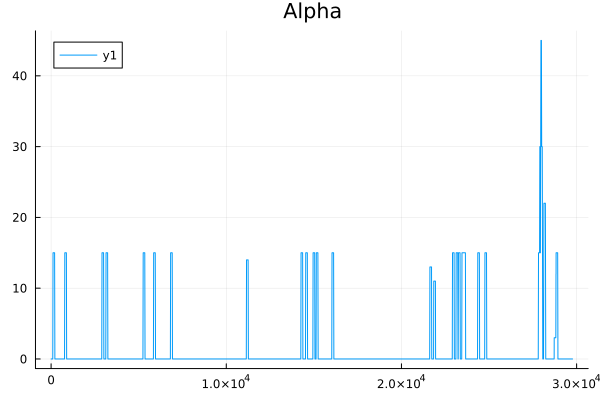

In [10]:
# Alpha, Gamma, Beta, Omicron, Delta

class, signals = input_data[1]

plot(signals[1], title=class)

In [ ]:
minlen = minimum(x -> minimum(length, x[2]), input_data)
maxlen = maximum(x -> maximum(length, x[2]), input_data)

@show minlen, maxlen

(minlen, maxlen) = (29684, 29789)


(29684, 29789)

## Classification Tests

### Decision Tree

In [ ]:
X = Vector{Vector{Float64}}()
encode::Dict{String,Float16} = Dict(
    "Alpha" => 0,
    "Gamma" => 1,
    "Beta" => 2,
    "Delta" => 3,
    "Omicron" => 4,
)
labels = Vector{Float16}()

for (class, signals) in input_data
    for signal in signals
        push!(X, signal[1:minlen])
        push!(labels, encode[class])
    end
end



### Multinomial Naive Bayes Implementation

1. Defining Model Structure

In [6]:
struct MultinomialNaiveBayes
    classes::Vector{Any}
    priors::Dict{Any, Float64}       # Class priors (log probabilities)
    feature_log_probs::Dict{Any, Vector{Float64}}  # Log probabilities of features per class
end

2. Implementing Training Function

In [7]:
function fit_multinomial_nb(
    X::Matrix{Int64},  # Input must be integer counts
    y::Vector;
    alpha::Float64 = 1.0  # Laplace smoothing parameter
)
    classes = unique(y)
    n_samples, n_features = size(X)
    priors = Dict{eltype(y), Float64}()
    feature_log_probs = Dict{eltype(y), Vector{Float64}}()

    for c in classes
        # Get samples of the current class
        mask = y .== c
        X_class = X[mask, :]
        n_class = size(X_class, 1)

        # Calculate class prior (log probability)
        priors[c] = log(n_class / n_samples)

        # Compute smoothed counts for each feature
        # Add alpha to avoid zero probabilities (Laplace smoothing)
        count = vec(sum(X_class, dims=1)) .+ alpha
        total_count = sum(count)
        
        # Compute log probabilities (normalize counts to probabilities and take log)
        log_probs = log.(count ./ (total_count + alpha * n_features))
        feature_log_probs[c] = log_probs
    end

    MultinomialNaiveBayes(classes, priors, feature_log_probs)
end

fit_multinomial_nb (generic function with 1 method)

3. Prediction Function

In [11]:
function predict(model::MultinomialNaiveBayes, X::Matrix{Int64})
    n_samples = size(X, 1)
    predictions = Vector{eltype(model.classes)}(undef, n_samples)

    for i in 1:n_samples
        x = X[i, :]
        max_log_prob = -Inf
        best_class = model.classes[1]

        for c in model.classes
            # Log prior for the class
            log_prior = model.priors[c]
            
            # Log likelihood: sum (x_j * log(feature_prob_j))
            log_likelihood = dot(x, model.feature_log_probs[c])
            
            # Total log probability
            total_log_prob = log_prior + log_likelihood

            if total_log_prob > max_log_prob
                max_log_prob = total_log_prob
                best_class = c
            end
        end

        predictions[i] = best_class
    end

    predictions
end

predict (generic function with 1 method)

### Testing Classification

In [ ]:
# Example: Text classification (word counts)
# 3 samples, 4 features (word counts), 2 classes
X = [
    1 2 0 1;  # Class 0
    0 1 3 2;  # Class 0
    2 0 1 1;   # Class 1
]
y = [0, 0, 1]

# Train the model
model = fit_multinomial_nb(X, y, alpha=1.0)

# Predict a new sample (e.g., word counts [2, 1, 0, 0])
new_sample = [2 1 0 0]
predicted_class = predict(model, new_sample)

1-element Vector{Any}:
 0

In [8]:
rndForest = RandomForestRegressor()

X_matrix = reduce(hcat, X) |> permutedims

# Ensure y is a row vector with correct dimensions (1 x n_samples)
DecisionTree.fit!(rndForest, X_matrix, labels)

RandomForestRegressor
n_trees:             10
n_subfeatures:       -1
partial_sampling:    0.7
max_depth:           -1
min_samples_leaf:    5
min_samples_split:   2
min_purity_increase: 0.0
ensemble:            Ensemble of Decision Trees
Trees:      10
Avg Leaves: 11.0
Avg Depth:  5.3

In [14]:

classeqs = Vector{String}()

wnwSize::UInt16 = ceil(UInt16, minlen * wnwPercent)

for v in eachindex(variantDirs)
    class = variantDirs[v]
    for record in open(FASTAReader, "/home/salipe/Desktop/datasets/test_voc/test/$class.fasta")
        seq::String = sequence(String, record)
        push!(classeqs, seq)
        break
    end
end

data = Model.wndwSequencesKmersHistogram(kmerset, wnwSize, classeqs)




5-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

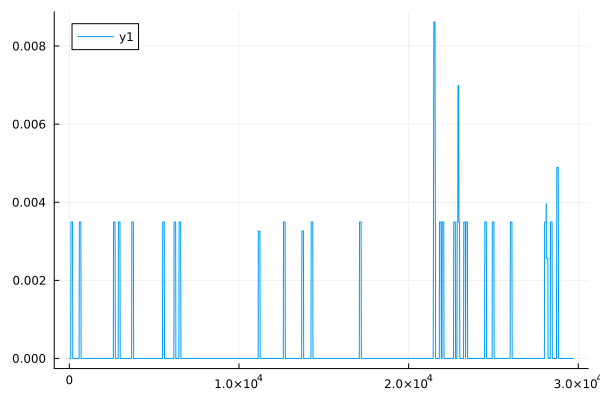

In [23]:
plot(data[4])

In [20]:
input = reduce(hcat, data) |> permutedims
raw_output = predict(rndForest, input)

raw_output

5-element Vector{Float16}:
 0.0
 1.967
 3.0
 1.0
 4.0